# Reference mapping with HNOCA-tools
In this tutorial we'll explore how to perform reference mapping using the HNOCA toolbox. Analogous to our analysis in the HNOCA manuscript, we map an organoid morphogen screen dataset ([Amin at al.](https://www.biorxiv.org/content/10.1101/2023.05.31.541819v1.full.pdf)) to a reference atlas of the developing human brain ([Braun at al.](https://www.science.org/doi/10.1126/science.adf1226)). We already trained a [scANVI](https://docs.scvi-tools.org/en/stable/user_guide/models/scanvi.html) model for this. Based on this model HNOCA-tools provides functions to map the organoid data to the reference atlas and make quantitative comparisons.

To get started, we first load all necessary pacakges and load the data & model.

In [4]:
import os
import scvi 
import scanpy as sc
import pandas as pd
import numpy as np
import hnoca.map as hmap

os.chdir("/home/fleckj/scratch/hnoca/")

In [2]:
# Read reference and query data
ref_adata = sc.read("BraunLinnarsson_2023_devbrain_hv2k.h5ad")
query_adata = sc.read("AminPasca_2023_organoid_screen_hv2k.h5ad")

# Format batch columns
query_adata.obs["batch"] = query_adata.obs["orig.ident"].astype(str).copy()
ref_adata.obs["batch"] = ref_adata.obs["Donor"].astype(str).copy()

# Load reference model
ref_model = scvi.model.SCANVI.load(
    "scarches_BraunLinnarsson/model.pt",
    adata=ref_adata,
)
print(ref_model)

Trainer will use only 1 of 8 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=8)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.


INFO     File scarches_BraunLinnarsson/model.pt/model.pt already downloaded                                        


ScanVI Model with the following params: 
unlabeled_category: Unknown, n_hidden: 256, n_latent: 20, n_layers: 2, dropout_rate: 0.2, dispersion: gene, 
gene_likelihood: zinb
Training status: Trained
Model's adata is minified?: False

Now we can use the `AtlasMapper` from HNOCA-tools to map the organoid data to the reference atlas. Under the hood this is using the transfer learning functionality of scANVI to finetune te model to the query dataset. We finetune for 100 epochs (`max_epochs`) with a batch size of 1024 (`batch_size`) and use `retrain="partial"` to only retrain the weights corresponding to the new batch covariates. 

In [5]:
# Initiate mapper
mapper = hmap.AtlasMapper(ref_model)
# Map query data to reference
mapper.map_query(
    query_adata, 
    retrain="partial", 
    max_epochs=100, 
    batch_size=1024
)

INFO     Found 100.0% reference vars in query data.                                                                


Trainer will use only 1 of 8 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=8)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.


INFO     Training for 100 epochs.                                                                                  


Trainer will use only 1 of 8 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=8)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
You are using a CUDA device ('NVIDIA A100-SXM4-40GB') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Epoch 100/100: 100%|██████████| 100/100 [02:47<00:00,  1.66s/it, v_num=1, train_loss_step=1.07e+3, train_loss_epoch=1.1e+3]

`Trainer.fit` stopped: `max_epochs=100` reached.


Epoch 100/100: 100%|██████████| 100/100 [02:47<00:00,  1.68s/it, v_num=1, train_loss_step=1.07e+3, train_loss_epoch=1.1e+3]


We then compute a weighted kNN graph between the query and reference data.

In [6]:
mapper.compute_wknn(k=100)

INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             
GPU detected and cuml installed. Use cuML for neighborhood estimation.
GPU detected and cuml installed. Use cuML for neighborhood estimation.


Based on this wkNN mapping, we can now transfer labels from the reference and to estimate cell type composition of the query. We can also compute presence scores with respect to the reference data to assess which reference cell types are covered in the screen.

In [12]:
subregion_transfer = mapper.transfer_labels(label_key="CellClass")
subregion_transfer[["best_label", "best_score"]]

,best_label,best_score
44_33_8__s1,Radial glia,1.789107
44_79_20__s1,Radial glia,0.617641
44_23_10__s1,Radial glia,1.113593
15_50_8__s1,Neurolast,0.360920
15_86_61__s1,Neurolast,0.315698
...,...,...
6_94_77__s8,Neuron,0.563865
35_39_65__s8,Oligo,16.431843
30_36_44__s8,Neuron,0.666777
30_56_8__s8,Neuron,0.315283


Let's check how this looks on a UMAP. We can see that this matches the original author annotations (`"class"`) quite well.

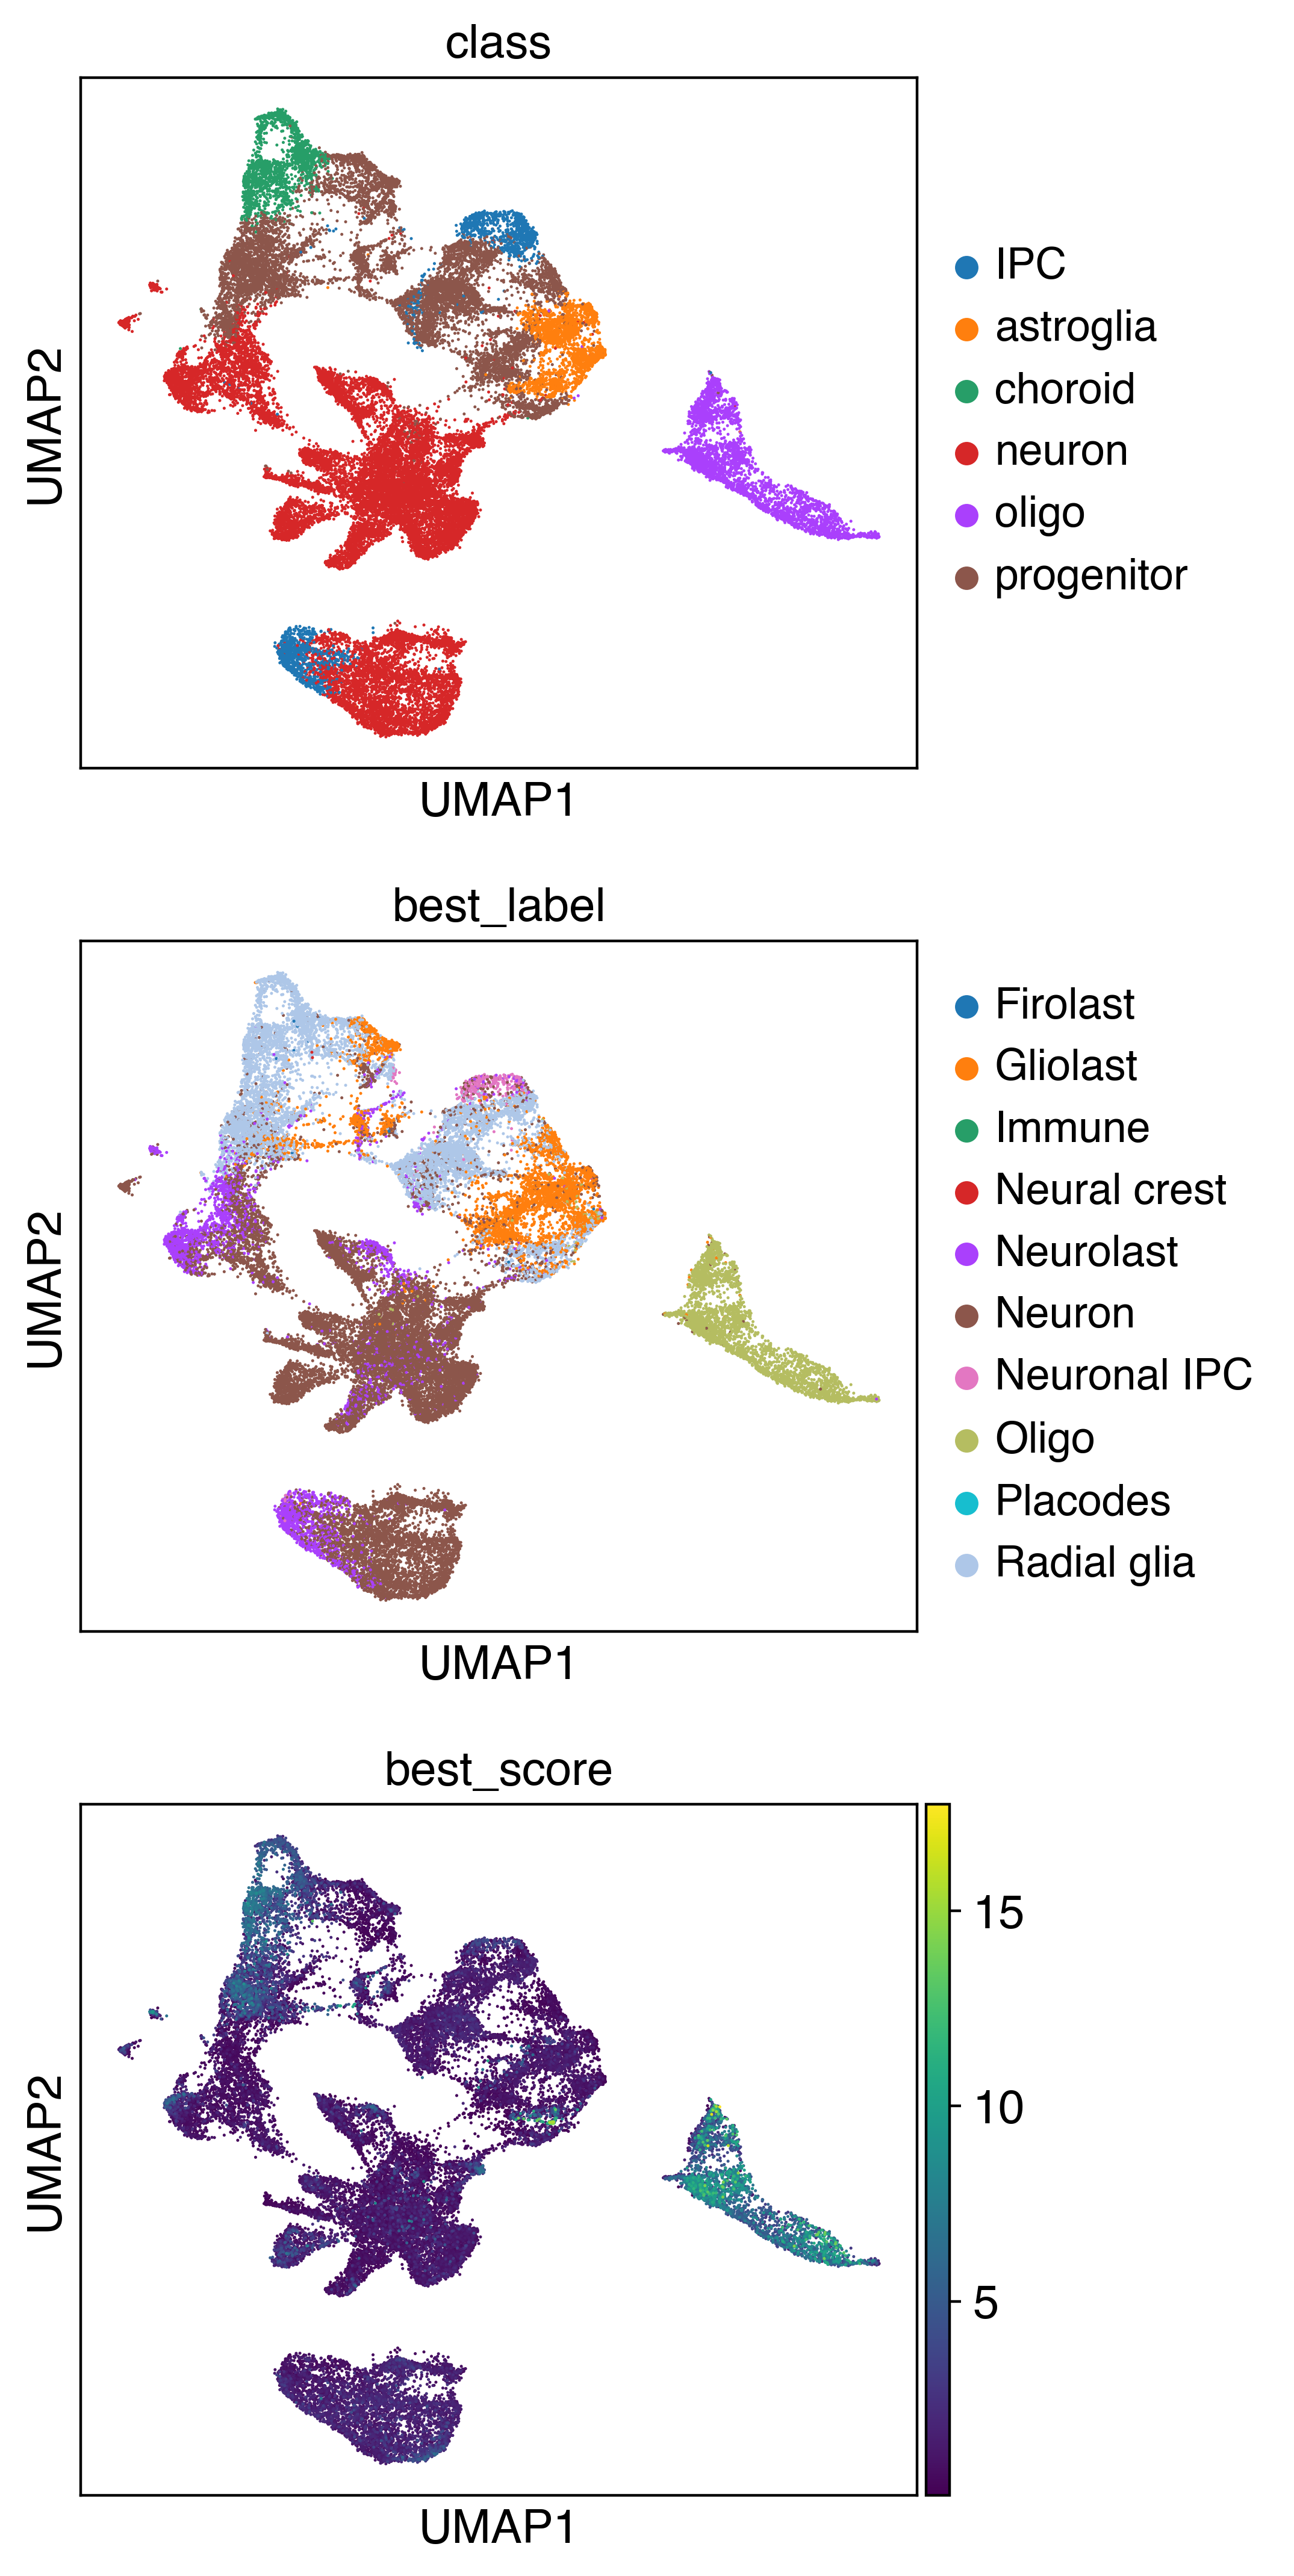

In [18]:
query_adata.obs["best_label"] = subregion_transfer["best_label"]
query_adata.obs["best_score"] = subregion_transfer["best_score"]
sc.pl.umap(query_adata, color=["class", "best_label", "best_score"], ncols=1)

Next, we'd like to know which cell types of the reference atlas are covered by the organoid screen. For this, we can compute the per-condition presence scores based on the wkNN graph.

In [19]:
presence_scores = mapper.get_presence_scores(split_by="condition")

AttributeError: 'AtlasMapper' object has no attribute 'estimate_presence_scores'